# Figure 3- HLA

In [1]:
import NotebookImport
from Setup.Imports import *

importing IPython notebook from Setup/Imports

Populating the interactive namespace from numpy and matplotlib


In [2]:
from Setup.Read_HIV_Data import *

importing IPython notebook from Setup/Read_HIV_Data

In [3]:
import Setup.DX_Imports as dx

importing IPython notebook from Setup/DX_Imports

Set of patients used in analysis of age advancement

importing IPython notebook from Parallel/Age_HIV_Features

importing IPython notebook from HIV_Age_Advancement

importing IPython notebook from Setup/MethylationAgeModels

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   5.2138     0.9326    5.59 1.25e-07 ***
chron_age     0.9790     0.0600   16.32  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 4.886 on 132 degrees of freedom
Multiple R-squared:  0.6685,	Adjusted R-squared:  0.666 
F-statistic: 266.2 on 1 and 132 DF,  p-value: < 2.2e-16


                2.5 %   97.5 %
(Intercept) 3.3689637 7.058680
chron_age   0.8602881 1.097651



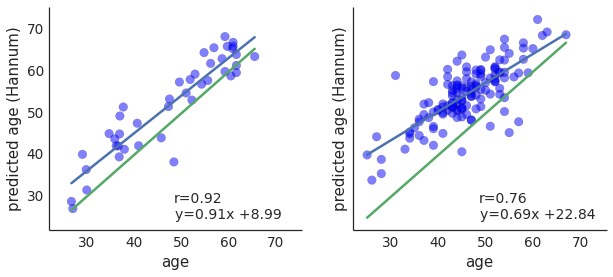

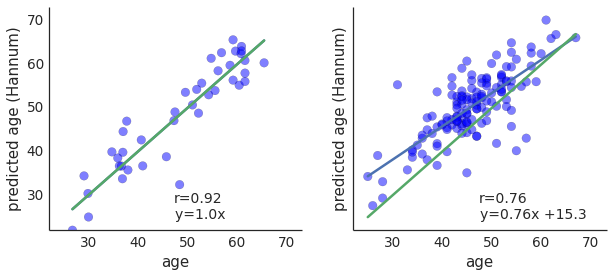

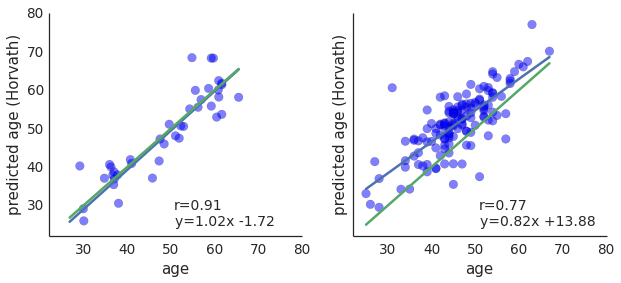

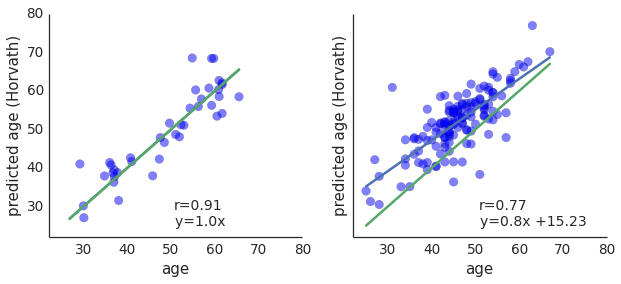

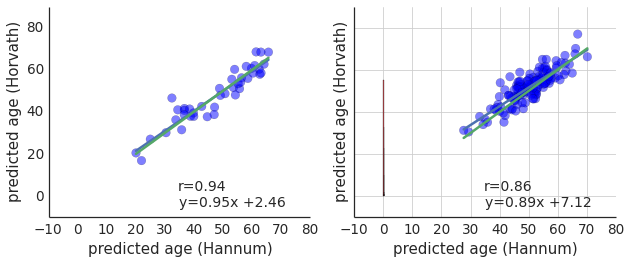

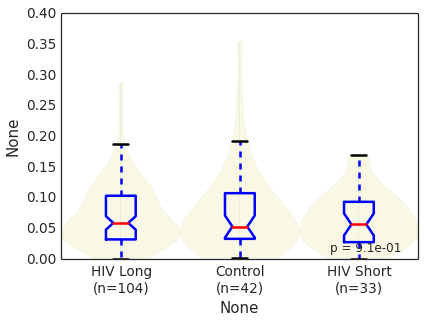

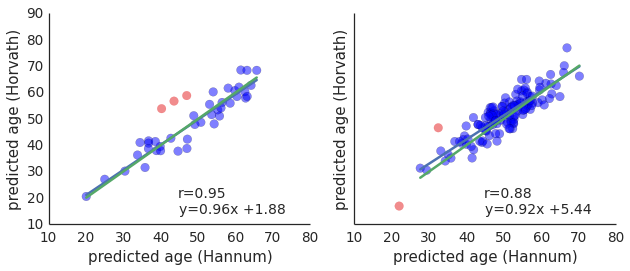

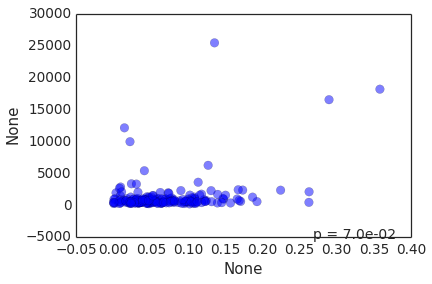

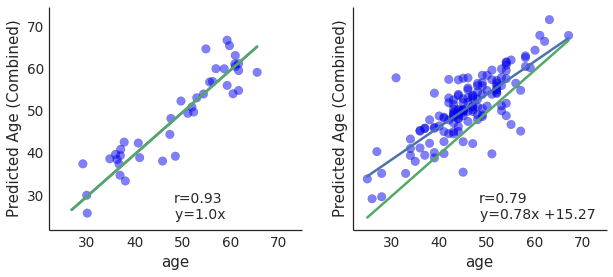

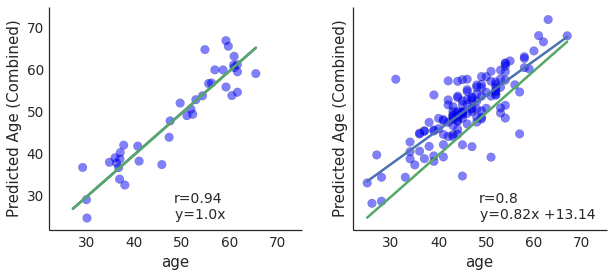

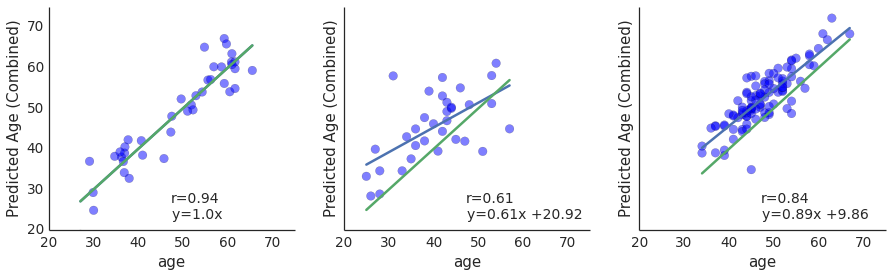

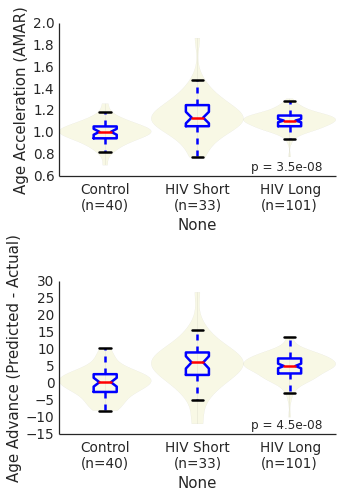

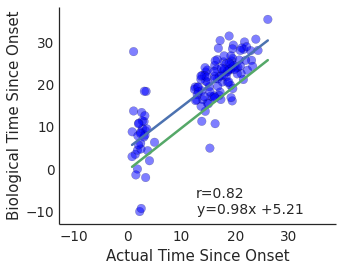

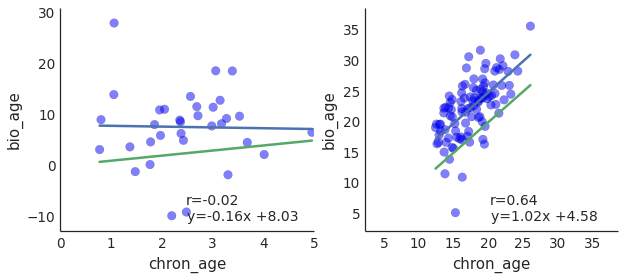

In [4]:
import Parallel.Age_HIV_Features as fx

In [5]:
keepers = fx.pred_c.index

In [6]:
features = {'Age only': fx.features['Age (BH)'],
            'HIV + Age': fx.features['HIV + Age (BH)'],
            'HIV only': fx.features['HIV (BH)']}

probes_sets = {'PRC2': dx.prc2_probes, 'CpG island': dx.cpg_island,
               'DHS': dx.dhs_site, 'Enhancer': dx.enhancer,
               'Gene body': dx.gene_body, 'TSS': dx.gene_tss,
               'Promoter': dx.promoter}

In [7]:
c1 = pd.DataFrame({i:v.value_counts() for i,v in features.iteritems()}).T
c1

,False,True
Age only,451748,21296
HIV + Age,467413,5631
HIV only,397314,75730


In [8]:
c2 = pd.DataFrame({i:v.value_counts() for i,v in probes_sets.iteritems()}).T
c2

,False,True
CpG island,314588,130023
DHS,425596,59916
Enhancer,382953,102559
Gene body,309941,175571
PRC2,406430,79082
Promoter,387422,98090
TSS,345509,140003


# Screen for Epigenetic Hotspots

Here I am explicitly looking for things that trend away from 50% methylation. 

In [9]:
ann = dx.probe_annotations.sort(['Chromosome','Genomic_Coordinate'])

In [10]:
from Setup.DX_Imports import ttest_df

In [11]:
t_hiv = ttest_df(fx.hiv == 'HIV+', fx.df_hiv)

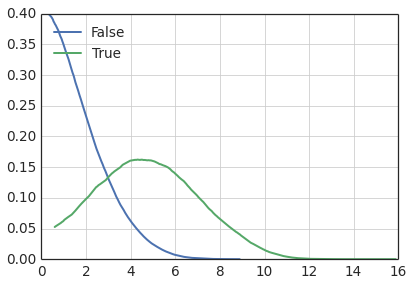

In [12]:
draw_dist(t_hiv.abs(), fx.g_hiv)

In [13]:
a,b = match_series((fx.mm > .5), (fx.r4.multi_variate.HIV < 0))
a,b = match_series(a,b)
direction = a == b

hiv_bh = fx.g_hiv
hiv_bh = (hiv_bh & (direction == False) & (fx.g_age == False)).dropna()
hiv_bh = hiv_bh.ix[probe_idx].ix[ann.index].dropna()
#hiv_bh = hiv_bh & (t_hiv.abs() > 1) 
hiv_bh.value_counts()

False    447553
True      25491
dtype: int64

In [14]:
def manhattan(vec, chrom, coords, ax=None, ybound=None,
              flow='up', ticks=True, gap=3e7):
    fig, ax = init_ax(ax, figsize=(9,3))
    x = 0
    chr_coords = []
    for i,c in enumerate(map(str, range(1,23))):
        v = vec.ix[ti(chrom == c)].dropna()
        series_scatter(coords + x, v, s=10, ax=ax, 
                       color=colors[i % 5], 
                       ann=None, alpha=1, rasterized=True) 
        chr_len = coords.ix[v.index].max()
        x = x + chr_len + gap
        chr_coords += [x - (chr_len / 2.)]
    ax.set_xbound(gap, x + gap)
    if ybound is not None:
        ax.set_ybound(ybound[0],ybound[1])
    ax.set_xlabel('Chromosome')
    
    if ticks:
        ax.set_xticks(chr_coords)
        ax.set_xticklabels(map(str, range(1,23)))
    else:
        ax.set_xticks([])
    top = flow == 'down'
    prettify_ax(ax, top)

In [15]:
m = hiv_bh.mean()
w = 200
t = lambda s: sp.stats.binom_test(s, w, p=m)
v = pd.concat([pd.rolling_mean(s, w, center=True) for i,s in 
               hiv_bh.groupby(ann.Chromosome)])
lookup = pd.Series({i: t(i) for i in (v.dropna() * w).unique()})
biom_p = (v.dropna() * w).map(lookup).order()

### Loading in GWAS Data

In [16]:
gwas = pd.read_csv('./data/Euro_CHAVI_Setpoint_liftover.csv', index_col=0)
gwas.chromosome = gwas.chromosome.astype(str)

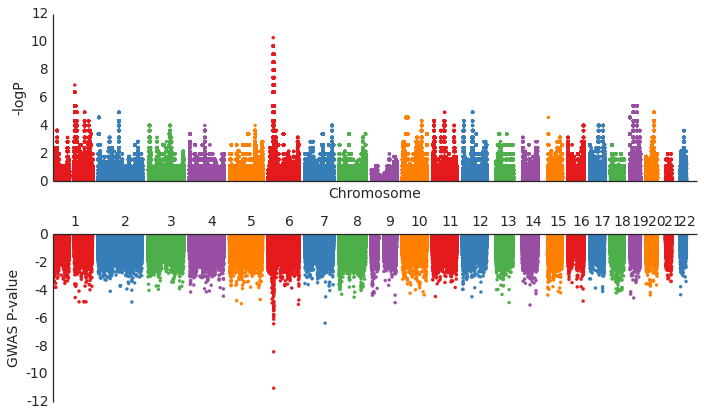

In [17]:
fig, axs = subplots(2,1, figsize=(10, 6))

ax = axs[0]
manhattan(-1*np.log10(biom_p), ann.Chromosome, ann.Genomic_Coordinate,
          ybound=[0,12], ax=ax, ticks=False)

ax.set_yticks(range(0, 13, 2))
#ax.set_yticklabels(range(0, 26, 5), size=14)
ax.set_xlabel('Chromosome', size=14)
axs[0].set_ylabel('-logP',
                  size=14)

ax = axs[1]
manhattan(-1*gwas['-logP'], gwas.chromosome, gwas.Map,
          ybound=[-12,0], ax=ax, flow='down')
ax.set_ylabel('GWAS P-value', size=14)
ax.set_yticks(range(-12, 1, 2))
ax.set_yticklabels(range(-12, 1, 2), size=14)
ax.set_xticklabels(range(1,23), size=14)
ax.set_xlabel('')

fig.tight_layout()
fig.savefig(FIGDIR + 'fig3_cd_n.pdf', dpi=300)

Look for associations with CD4T counts of HIV-associated probes

In [18]:
df = df_hiv.ix[ti(hiv_bh.dropna())]
df = df.ix[:, keepers.intersection(ti(fx.hiv == 'HIV+'))]
df = df.sub(df.mean(1), axis=0).div(df.std(1), axis=0)

In [19]:
corr_with_cd4_m = screen_feature(np.log2(labs['CD4/CD8 ratio']), spearman_pandas, df,
                               align=False)

In [20]:
corr_with_cd4_m.head()

,rho,p,q
cg24351901,0.44,1.53e-07,0
cg06872964,0.42,4.57e-07,0
cg12752647,-0.42,5.41e-07,0
cg15473346,0.42,5.77e-07,0
cg23048215,0.41,1.00e-06,0


In [142]:
rr = (dm_cell.CD4T_mean - dm_cell.CD8T_mean)

In [143]:
spearman_pandas(rr, corr_with_cd4_m.rho)

rho    3.65e-02
p      1.32e-08
dtype: float64

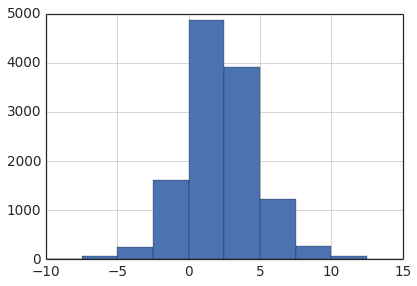

In [146]:
vv = np.log2(corr_with_cd4_m.rho / rr).clip(-10,15).dropna()
vv.hist()

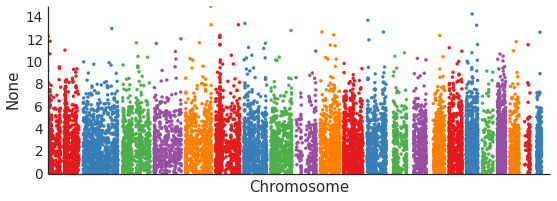

In [148]:
manhattan(vv.abs(), ann.Chromosome, ann.Genomic_Coordinate,
          ybound=[0,15], ticks=False)

In [111]:
dm_cell.ix['cg06872964']

Fstat         6.60e+00
p.value       2.98e-04
CD8T_mean     6.07e-01
CD4T_mean     5.02e-01
NK_mean       6.20e-01
Bcell_mean    5.55e-01
Mono_mean     5.07e-01
Gran_mean     4.73e-01
DNAm_low      4.14e-01
DNAm_high     7.19e-01
DNAm_range    3.05e-01
Name: cg06872964, dtype: float64

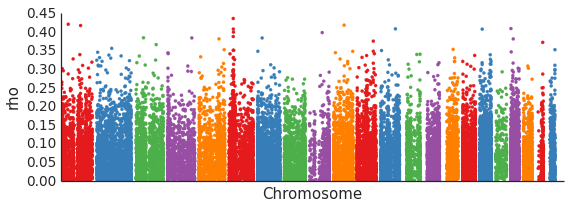

In [21]:
manhattan(corr_with_cd4_m.rho.abs(), ann.Chromosome, ann.Genomic_Coordinate,
          ybound=[0,.45], ticks=False)

In [29]:
dm_cell = pd.read_csv('./data/Jaffee_Supplementary_Table_2.csv', index_col=0,
                      low_memory=False, skiprows=[0])

In [77]:
ss = -1*np.sign(fx.r4.multi_variate.HIV)

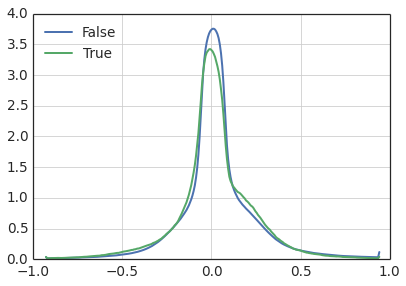

In [78]:
rr = np.log2(dm_cell.CD4T_mean / dm_cell.CD8T_mean).clip(-1.,1.)
draw_dist(rr*ss, hiv_bh)

In [79]:
hla_region = ((ann.Chromosome == '6') & 
              ann.Genomic_Coordinate.isin(range(29570008, 33377112)))

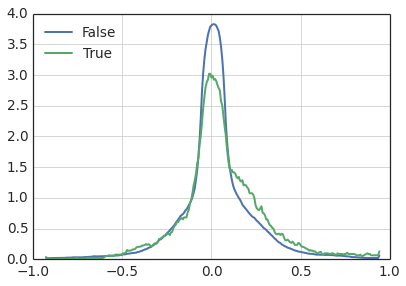

In [80]:
draw_dist(rr * ss, hiv_bh.ix[ti(hla_region)])

In [107]:
anova(hla_region, rr)

F    3.08e+02
p    5.01e-69
dtype: float64

In [76]:
pearson_pandas(corr_with_cd4_m.rho, rr)

rho   -0.00
p      0.48
dtype: float64

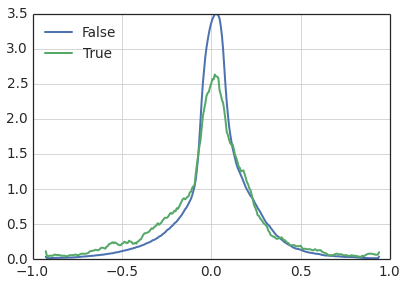

In [60]:
draw_dist(rr, corr_with_cd4_m.rho.abs() > .2)

In [23]:
fx.r4.ix['cg24351901']

multi_variate  HIV         -1.12e+00
               Intercept   -9.74e-01
               age          1.21e-02
               CD4T         2.26e+00
               CD8T         4.06e-01
               NK           3.39e-01
               Bcell        3.44e+00
               Mono        -1.43e+00
HIV_LR         LR           1.64e+01
               p            5.08e-05
               df           1.00e+00
Name: cg24351901, dtype: float64

### Zooming in on the HLA Region

In [43]:
hla_region = ((ann.Chromosome == '6') & 
              ann.Genomic_Coordinate.isin(range(29570008, 33377112)))

In [54]:
m = hiv_bh.mean()
sp.stats.binom_test(hiv_bh.ix[ti(hla_region)].sum(), 
                    n=len(hiv_bh.ix[ti(hla_region)].dropna()), p=m)

1.4716967693480401e-10

In [55]:
fisher_exact_test(hiv_bh, hla_region)

odds_ratio    1.30e+00
p             7.91e-11
dtype: float64

In [56]:
odds = pd.DataFrame({x: fisher_exact_test(hla_region, corr_with_cd4_m.rho.abs() > x)
                     for x in [.1, .15, .2, .25, .3, .35, .4]}).T
odds

,odds_ratio,p
0.10,1.01,9.34e-01
0.15,1.16,1.85e-01
0.20,1.02,9.26e-01
0.25,1.91,1.29e-02
0.30,3.00,4.85e-03
0.35,10.28,7.51e-05
0.40,11.37,2.03e-02


In [57]:
tt = dx.ttest_df(fx.hiv.ix[fx.pred_c.index] == 'HIV+', df_hiv.ix[probe_idx])

In [58]:
d = tt < 0
fisher_exact_test(hla_region, d)

odds_ratio    1.43e+00
p             4.53e-73
dtype: float64

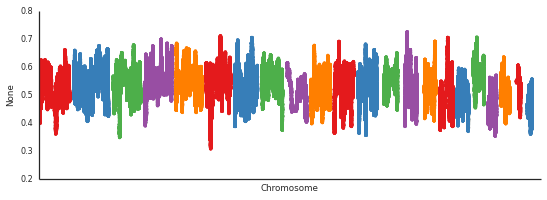

In [59]:
d = (tt > 0).ix[ann.index].dropna()
v = pd.concat([pd.rolling_mean(s, 500, center=True) for i,s in 
               d.groupby(ann.Chromosome)])
manhattan(v.dropna(), ann.Chromosome, ann.Genomic_Coordinate,
          ticks=False)

In [60]:
rcParams['axes.labelsize'] = 14
rcParams['xtick.labelsize'] = 14
rcParams['ytick.labelsize'] = 14

In [61]:
range(20000, 41000, 5000)

[20000, 25000, 30000, 35000, 40000]

In [62]:
tt = dx.ttest_df(fx.hiv.ix[fx.pred_c.index] == 'HIV+', df_hiv.ix[probe_idx])

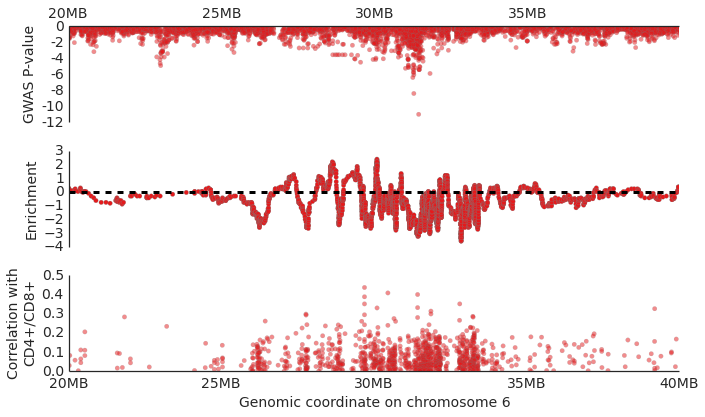

In [63]:
fig, axs  = subplots(3,1, figsize=(10,6), sharex=True)

ax=axs[0]
k = ti((gwas.chromosome == '6') & 
       gwas.Map.isin(range(20000000, 40000000)))
x = gwas.Map.ix[k]
rr = -1*gwas['-logP']

series_scatter(x, rr, color=colors[0],
               s=20, ax=ax, ann=None,
               edgecolor='grey')

ax.set_ylabel('GWAS P-value')
ax.set_yticks(range(-12, 1, 2))
ax.set_yticklabels(range(-12, 1, 2), size=14)
ax.set_ylim(-12,0)
ax.set_xlabel('')
#ax.axvspan(29570008, 33377112, alpha=.1)
ax.set_xbound(x.min(), x.max())
prettify_ax(ax, top=True)

k = ti((ann.Chromosome == '6') & 
       ann.Genomic_Coordinate.isin(range(20000000, 40000000)))
x = ann.Genomic_Coordinate.ix[k].order()

ax = axs[1]

d = (tt[tt.abs() > 0] > 0).ix[ann.index].dropna()
v = pd.concat([pd.rolling_mean(s, 200, center=True) for i,s in 
               d.groupby(ann.Chromosome)])
v = (v - v.mean()) / v.std()

series_scatter(x[::5], v.ix[x.index], s=20, ann=None, color=colors[0],
               edgecolor='grey', ax=ax, alpha=1)

ax.axhline(0, ls='--', color='black', lw=3)
ax.set_ylabel('Enrichment')
ax.spines['bottom'].set_visible(False)
#ax.axvspan(29570008, 33377112, alpha=.1)
ax.set_xbound(x.min(), x.max())
prettify_ax(ax)
ax.set_xlabel('')

ax = axs[2]
series_scatter(x, corr_with_cd4_m.rho.abs(),
               ax=ax, s=20, ann=None, color=colors[0],
               edgecolor='grey')
ax.set_xbound(x.min(), x.max())
ax.set_ylim(0)
ax.set_xticks([])
ax.set_ylabel('Correlation with\nCD4+/CD8+')
ax.set_xlabel('Genomic coordinate on chromosome 6')
#ax.axvspan(29570008, 33377112, alpha=.1)
ax.set_xbound(x.min(), x.max())
ax.set_xticks(range(20000000, 41000000, 5000000))
ax.set_xticklabels(['20MB','25MB','30MB','35MB','40MB'])
prettify_ax(ax)

fig.tight_layout()
fig.savefig(FIGDIR + 'fig3_efg.pdf', dpi=300)

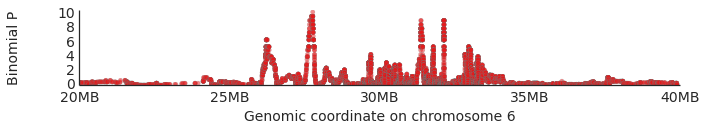

In [64]:
fig, ax  = subplots(1,1, figsize=(10,2), sharex=True)
series_scatter(x, -1*np.log10(biom_p).ix[x.index],
               ax=ax, s=20, ann=None, color=colors[0],
               edgecolor='grey')
ax.set_xbound(x.min(), x.max())
ax.set_ylim(0,10.5)
ax.set_xlabel('Genomic coordinate on chromosome 6')
ax.set_ylabel('Binomial P\n\n ')
ax.set_xbound(x.min(), x.max())
ax.set_xticks(range(20000000, 41000000, 5000000))
ax.set_xticklabels(['20MB','25MB','30MB','35MB','40MB'])
prettify_ax(ax)
fig.tight_layout()

In [65]:
full_region = ((ann.Chromosome == '6') & 
                   ann.Genomic_Coordinate.isin(range(25000000, 35000000)))
histone_region = ((ann.Chromosome == '6') & 
                   ann.Genomic_Coordinate.isin(range(25000000, 29570008)))
hla_region = ((ann.Chromosome == '6') & 
              ann.Genomic_Coordinate.isin(range(29570008, 33377112)))

In [66]:
b = biom_p.ix[ti(histone_region)].order()
b.name=  'b'
ann.ix[b.index].join(b).head(10)

,Gene_Symbol,Chromosome,Genomic_Coordinate,b
Composite Element REF,,,,
cg02295525,HIST1H2AI;HIST1H2BL,6,27775480,5.25e-11
cg25108566,HIST1H2AI;HIST1H2BL,6,27775657,2.10e-10
cg22310240,HIST1H2AI;HIST1H2BL,6,27775346,2.10e-10
cg11079354,NaN,6,27740361,2.10e-10
cg04285443,HIST1H2AI,6,27774969,2.10e-10
cg09379385,HIST1H2AI,6,27774865,2.10e-10
cg15024592,NaN,6,27771383,2.10e-10
cg22257747,NaN,6,27760706,2.10e-10
cg24704603,NaN,6,27760633,2.10e-10


In [67]:
fisher_exact_test(hiv_bh, full_region)

odds_ratio    1.34e+00
p             2.11e-17
dtype: float64

In [68]:
fisher_exact_test(hla_region, hiv_bh)

odds_ratio    1.30e+00
p             7.91e-11
dtype: float64

In [69]:
fisher_exact_test(hiv_bh, histone_region)

odds_ratio    1.46e+00
p             2.88e-07
dtype: float64

In [70]:
promoters = probes_sets['Promoter']
fisher_exact_test(hiv_bh.ix[ti(promoters)], histone_region)

odds_ratio    1.51e+00
p             3.47e-04
dtype: float64

In [71]:
fisher_exact_test(hiv_bh.ix[ti(promoters)], hla_region)

odds_ratio    1.35e+00
p             1.23e-05
dtype: float64

### Quick Promoter Analysis

* Want to check for the enricment with this region in the context of promoters 
* Doesn't seems to be a big effect, but it seems like promoters are more likely to be HIV associated within the HLA region

In [72]:
promoters = probes_sets['Promoter']

In [73]:
fisher_exact_test(promoters, hla_region)

odds_ratio    1.37e+00
p             2.27e-43
dtype: float64

In [74]:
cpg = probes_sets['CpG island']

In [75]:
fisher_exact_test(promoters, hiv_bh)

odds_ratio     1.55e+00
p             2.13e-193
dtype: float64

In [76]:
fisher_exact_test(promoters.ix[ti(hla_region)], hiv_bh)

odds_ratio    1.70e+00
p             1.24e-10
dtype: float64

In [77]:
fisher_exact_test(promoters.ix[ti(histone_region)], hiv_bh)

odds_ratio    1.77e+00
p             9.40e-05
dtype: float64

In [78]:
fisher_exact_test(hla_region.ix[ti(promoters==False)], hiv_bh)

odds_ratio    1.23e+00
p             4.15e-05
dtype: float64

In [79]:
fisher_exact_test(hla_region.ix[ti(promoters==True)], hiv_bh)

odds_ratio    1.35e+00
p             1.23e-05
dtype: float64